<h2> Robust components </h2>

In [1]:
import argparse
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.mixture import GaussianMixture as GMM
from utils import *
import numpy as np
import torch
import copy
import matplotlib.patches as patches

Import vanilla and robust genRKM

In [2]:
sd_mdl = torch.load('out/MNIST_vanilla_RKM_h128_oneview.tar', map_location=torch.device('cpu'))

net1 = sd_mdl['net1'].float().cpu()
net3 = sd_mdl['net3'].float().cpu()
net2 = sd_mdl['net2'].float().cpu()
net4 = sd_mdl['net4'].float().cpu()
net1.load_state_dict(sd_mdl['net1_state_dict'])
net3.load_state_dict(sd_mdl['net3_state_dict'])
net2.load_state_dict(sd_mdl['net2_state_dict'])
net4.load_state_dict(sd_mdl['net4_state_dict'])
h = sd_mdl['h'].float().detach().cpu()
s = sd_mdl['s'].float().detach().cpu()
V = sd_mdl['V'].float().detach().cpu()
U = sd_mdl['U'].float().detach().cpu()

sd_mdl_ = torch.load('out/MNIST_adv_RKM_h128_epoch200_pert30_oneview.tar', map_location=torch.device('cpu'))

net1_ = sd_mdl_['net1'].float().cpu()
net3_ = sd_mdl_['net3'].float().cpu()
net2_ = sd_mdl_['net2'].float().cpu()
net4_ = sd_mdl_['net4'].float().cpu()
net1_.load_state_dict(sd_mdl_['net1_state_dict'])
net3_.load_state_dict(sd_mdl_['net3_state_dict'])
net2_.load_state_dict(sd_mdl_['net2_state_dict'])
net4_.load_state_dict(sd_mdl_['net4_state_dict'])
h_ = sd_mdl_['h'].float().detach().cpu()
s_ = sd_mdl_['s'].float().detach().cpu()
V_ = sd_mdl_['V'].float().detach().cpu()
U_ = sd_mdl_['U'].float().detach().cpu()

In [3]:
np.linalg.matrix_rank(h.T)

128

In [4]:
#create list of values with multiples of 10

# Initialize the list
values = []

# Start with 0.1
current_value = 0.1

# Generate values down to 10^-10
while current_value >= 1e-10:
    values.append(current_value)
    current_value *= 0.1  # Multiply by 0.1 to get the next smaller value

print(values)

[0.1, 0.010000000000000002, 0.0010000000000000002, 0.00010000000000000003, 1.0000000000000004e-05, 1.0000000000000004e-06, 1.0000000000000005e-07, 1.0000000000000005e-08, 1.0000000000000005e-09, 1.0000000000000006e-10]


In [5]:
#for vanilla model
rank_list = []

for treshold in values:
    rank = torch.sum(s > treshold).item()
    rank_list.append(rank)

print(rank_list)

[128, 128, 128, 128, 4997, 5000, 5000, 5000, 5000, 5000]


In [6]:
#for robust model
rank_list_rob = []

for treshold in values:
    rank = torch.sum(s_ > treshold).item()
    rank_list_rob.append(rank)

print(rank_list_rob)

[128, 128, 128, 128, 133, 5000, 5000, 5000, 5000, 5000]


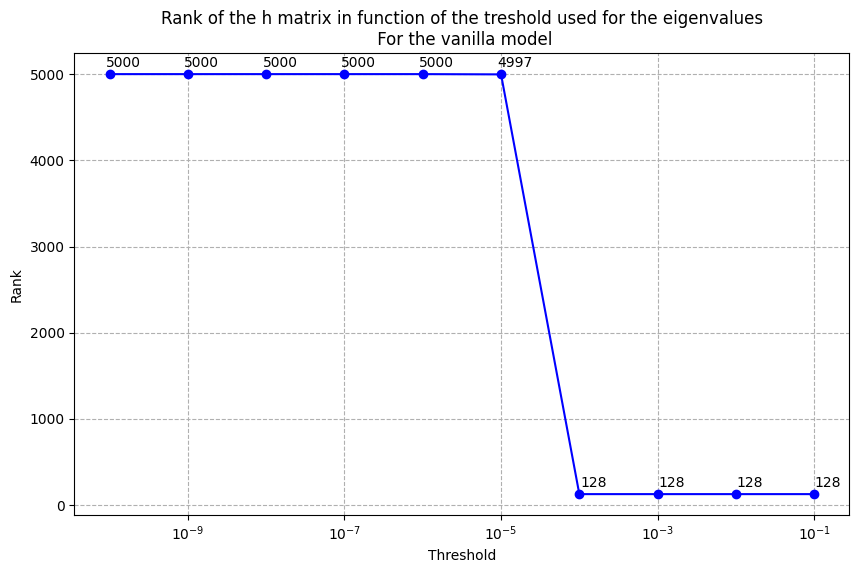

In [7]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(values, rank_list, marker='o', linestyle='-', color='b')

# Set the x-axis to a logarithmic scale
plt.xscale('log')

# Label the axes
plt.xlabel('Threshold')
plt.ylabel('Rank')

# Title for the plot
plt.title('Rank of the h matrix in function of the treshold used for the eigenvalues\n For the vanilla model')

# Annotate each point with the y value (rank)
for i, txt in enumerate(rank_list):
    plt.annotate(txt, (values[i], rank_list[i]), textcoords="offset points", xytext=(10,5), ha='center')


# Show grid for better readability
plt.grid(True, which="both", ls="--")

# Show the plot
plt.show()

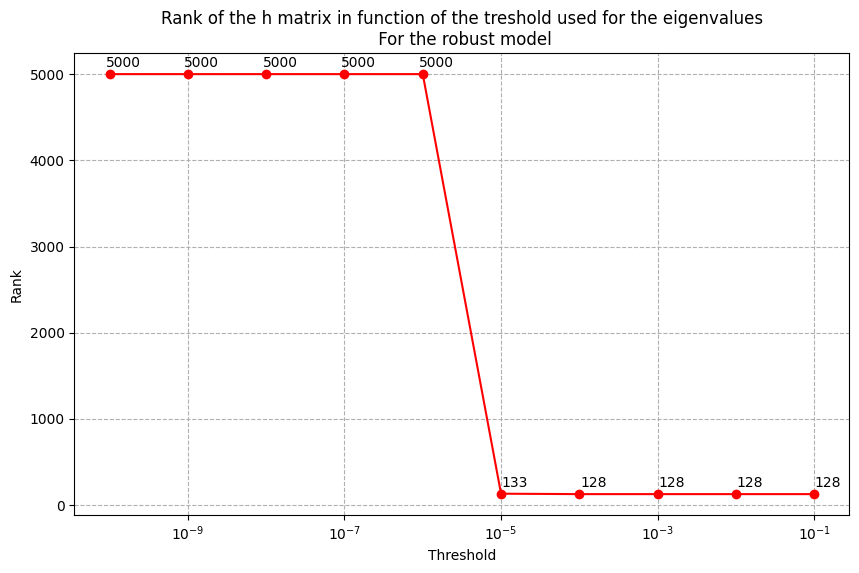

In [8]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(values, rank_list_rob, marker='o', linestyle='-', color='r')

# Set the x-axis to a logarithmic scale
plt.xscale('log')

# Label the axes
plt.xlabel('Threshold')
plt.ylabel('Rank')

# Title for the plot
plt.title('Rank of the h matrix in function of the treshold used for the eigenvalues\n For the robust model')

# Annotate each point with the y value (rank)
for i, txt in enumerate(rank_list_rob):
    plt.annotate(txt, (values[i], rank_list_rob[i]), textcoords="offset points", xytext=(10,5), ha='center')


# Show grid for better readability
plt.grid(True, which="both", ls="--")

# Show the plot
plt.show()

In [9]:
print(h.shape)
print(h.type)

torch.Size([5000, 128])
<built-in method type of Tensor object at 0x000001C536356570>


In [10]:
# Perform Singular Value Decomposition (SVD)
u, s, v = torch.svd(h)
#should be done on the kernel matrix and not on "h"

rank = torch.sum(s > 1e-3).item()

print(f"computed eigenvalues from svd:\n{s}")

print(rank)



computed eigenvalues from svd:
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1

In [11]:
# Perform Singular Value Decomposition (SVD)
u, s, v = torch.svd(h_)

# Determine the rank by counting the number of non-zero singular values
# Note: Use a threshold to consider numerical stability
rank = torch.sum(s > 1e-3).item()

print(rank)

128


In [12]:
test = torch.tensor([[1, 2, 3], [2, 4, 6], [7, 8, 9]], dtype=torch.float)

# Perform Singular Value Decomposition (SVD)
u, s, v = torch.linalg.svd(test)

rank = torch.sum(s > 1e-3).item()

print(rank)

2


Functions for similarity

In [13]:
def euclidean_distance(vec1, vec2):
    return np.min([np.linalg.norm(vec1 - vec2), np.linalg.norm(vec1 + vec2)])

def cosine_similarity(vec1, vec2):
    dot_product = np.max([np.dot(vec1, vec2), np.dot(vec1, -vec2)])
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

In [14]:
cosine_similarity(np.array([1,1]),np.array([-1,-1]))

0.9999999999999998

In [15]:
euclidean_distance(np.array([1,1]),np.array([1,1]))

0.0

Similarities

In [16]:
euc_dist = []
cos_sim = []

In [17]:
for col1, col2 in zip(torch.t(h), torch.t(h_)):
    euclidean_dist = euclidean_distance(col1, col2)
    cosine_sim = cosine_similarity(col1, col2)
    euc_dist.append(euclidean_dist)
    cos_sim.append(cosine_sim)
#     print(f"Euclidean Distance: {euclidean_dist}, Cosine Similarity: {cosine_sim}")
#
print(np.argsort(euc_dist))
print(np.argsort(cos_sim))

print(len(euc_dist))

[  2  14  11   8   5  33   0  19  29  18  45   9  36  38  34   1  17  54
  42  12  20  30  10   4  43  31  63  48  26  61  44  15  13  21  56  58
  52  22   3  41  60  39  46  35  23  71  90   7  59  69  28  75  55  83
 104  40  57  89  73  79 101 102  72  74  50  91  51  95  68  70  47  99
  97  24  62  65 105 127  94  93  82  88  64  92  98 124 118  67 122  53
 110  86  96  76 119 123 106  66 121  77 120   6 100  81 117 116  84 108
  87 103  85 109 114  25 115  16 126 113 125  32 111  78  27  80  49  37
 107 112]
[112 107  37  49  80  27  78 111  32 125 113 126  16 115  25 114 109  85
 103  87 108  84 116 117  81 100   6 120  77 121  66 106 123 119  76  96
  86 110  53 122  67 118 124  98  92  64  88  82  93  94 127 105  65  62
  24  97  99  47  70  68  95  51  91  50  74  72 102 101  79  73  89  57
  40 104  83  55  75  28  69  59   7  90  71  23  35  46  39  60  41   3
  22  52  58  56  21  13  15  44  61  26  48  63  31  43   4  10  30  20
  12  42  54  17   1  34  38  36   9  45 

In [18]:
print(cos_sim)

[0.51800835, 0.36498737, 0.718703, 0.15550889, 0.27411982, 0.5943696, 0.027946142, 0.12784106, 0.6035737, 0.39272025, 0.277674, 0.6622816, 0.3268008, 0.21295355, 0.67668885, 0.21910577, 0.0137006715, 0.36063936, 0.39762652, 0.48423502, 0.28784555, 0.1828731, 0.16679724, 0.14243793, 0.054185506, 0.015421172, 0.22890997, 0.0052147023, 0.119973265, 0.42599595, 0.28015447, 0.25403252, 0.0078564, 0.5254192, 0.369301, 0.14558429, 0.39240384, 0.0036602572, 0.38102877, 0.14890431, 0.10412607, 0.15192634, 0.3305034, 0.26079342, 0.21963425, 0.39726958, 0.14689903, 0.0641338, 0.24435697, 0.0045626084, 0.07665892, 0.07576245, 0.17560276, 0.03971759, 0.3431197, 0.11417853, 0.18278544, 0.10351487, 0.17868443, 0.1252234, 0.14984933, 0.22001462, 0.053860564, 0.24624804, 0.048650898, 0.05302634, 0.03198122, 0.042549077, 0.067311235, 0.121597245, 0.064856336, 0.14184257, 0.08377029, 0.09075422, 0.082311645, 0.1144486, 0.036217686, 0.029654557, 0.0062964424, 0.08691252, 0.004967128, 0.027407216, 0.049978

In [19]:
eucl_matrix = np.zeros((h.shape[1],h_.shape[1]))
cos_matrix =  np.zeros((h.shape[1],h_.shape[1]))

In [20]:
len(eucl_matrix)

128

In [21]:
print(len(h[:,0]))
print(h.shape[1])

5000
128


In [22]:
#NOT CORRECT
iteration = 0
for i in range(h.shape[1]):
    
    #latent component of vanilla genRKM
    ele_van = h[:,i]

    for j in range(i,h_.shape[1]): #matrix is symmetric, so compute the upper triangle matrix only
        
        #latent component of robust genRKM
        ele_rob = h_[:,j]

        eucl_dist = euclidean_distance(ele_van, ele_rob)
        cos_sim = cosine_similarity(ele_van, ele_rob)
    
        eucl_matrix[i,j] = eucl_dist
        cos_matrix[i,j] = cos_sim

        #matrix is symmetric
        eucl_matrix[j,i] = eucl_dist
        cos_matrix[j,i] = cos_sim

    print(f"iteration: {iteration}")
    iteration += 1

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68
iteration: 69
iteration: 70
iteration: 71
it

In [45]:
iteration = 0
for i in range(h.shape[1]):
    
    #latent component of vanilla genRKM
    ele_van = h[:,i]

    for j in range(h_.shape[1]): #matrix is symmetric, so compute the upper triangle matrix only
        
        #latent component of robust genRKM
        ele_rob = h_[:,j]

        eucl_dist = euclidean_distance(ele_van, ele_rob)
        cos_sim = cosine_similarity(ele_van, ele_rob)
    
        eucl_matrix[i,j] = eucl_dist
        cos_matrix[i,j] = cos_sim

    print(f"iteration: {iteration}")
    iteration += 1

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68
iteration: 69
iteration: 70
iteration: 71
it

In [46]:
array_cos_matrix = np.array(cos_matrix)
array_eucl_matrix = np.array(eucl_matrix)

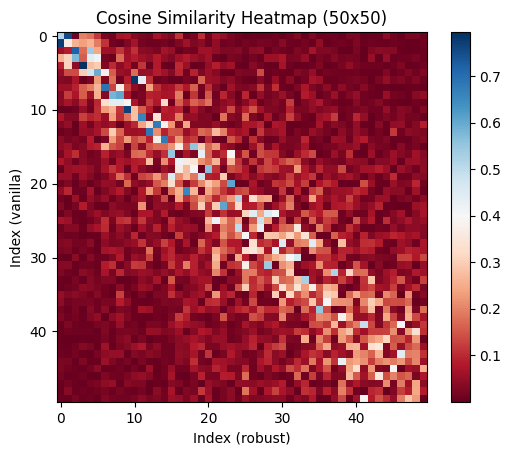

In [61]:
nbr_components = 50

# Create a heatmap
plt.imshow(array_cos_matrix[:nbr_components,:nbr_components], cmap='RdBu', interpolation='nearest') #viridis

# Add color bar to show the scale
plt.colorbar()

# Add title and labels if needed
plt.title(f'Cosine Similarity Heatmap ({nbr_components}x{nbr_components})')
plt.xlabel('Index (robust)')
plt.ylabel('Index (vanilla)')

# Display the heatmap
plt.show()

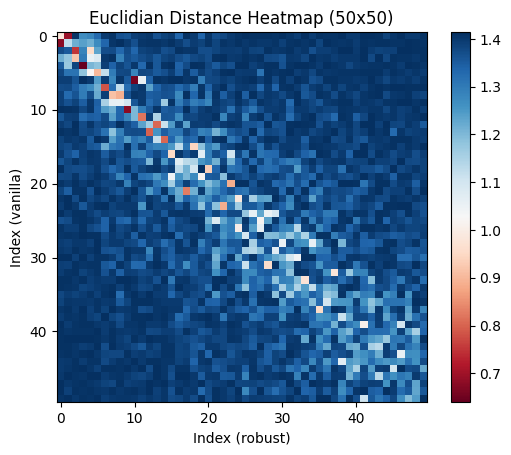

In [63]:
nbr_components = 50

# Create a heatmap
plt.imshow(array_eucl_matrix[:nbr_components,:nbr_components], cmap='RdBu', interpolation='nearest')

# Add color bar to show the scale
plt.colorbar()

# Add title and labels if needed
plt.title(f'Euclidian Distance Heatmap ({nbr_components}x{nbr_components})')
plt.xlabel('Index (robust)')
plt.ylabel('Index (vanilla)')

# Display the heatmap
plt.show()

In [49]:
# Initialize the new matrix with zeros
cos_matrix_highest = np.zeros_like(cos_matrix)

# Get the index of the maximum value in each row
max_indices = np.argmax(cos_matrix, axis=1)

# Set the corresponding indices to 1
for i, idx in enumerate(max_indices):
    cos_matrix_highest[i, idx] = 1

In [50]:
np.argmax(cos_matrix_highest[0])
np.argmax(eucl_matrix[0])

41

In [51]:
print(max_indices)

counter_same_pos = 0

for i in range(len(max_indices)):
    if(i==max_indices[i]):
        counter_same_pos += 1

print(f"same position: {counter_same_pos}")

counter_pos_1 = 0

for i in range(len(max_indices)):
    if(i+1>=max_indices[i] and i-1<=max_indices[i]):
        counter_pos_1 += 1

print(f"Bandwith +/- 1: {counter_pos_1}")

counter_pos_n = 0
n = 2

for i in range(len(max_indices)):
    if(i+n>=max_indices[i] and i-n<=max_indices[i]):
        counter_pos_n += 1

print(f"Bandwith +/- {n}: {counter_pos_n}")

[  1   0   2   2   3   5  10   6   8   8   9  11  13  12  14  18  15  16
  20  19  23  17  24  22  28  27  24  25  30  29  32  28  37  33  34  31
  36  35  38  41  48  64  43  46  38  45  43  55  59  41  59  50  68  51
  54  52  54  66  57  49  74  57  72  67  68  60  79  56  66  73  83  76
  55  65  85  96  80  80  85  82  90  78  76  68  77 127  58 101  95  75
 119  70 101  94  97  78  79  82  85  79  89 100 123  93  82  95  71 113
  84  91  94 104 109  76 109  86  81  86 127  88 119  73  78  76 107  97
 115 124]
same position: 13
Bandwith +/- 1: 31
Bandwith +/- 2: 43


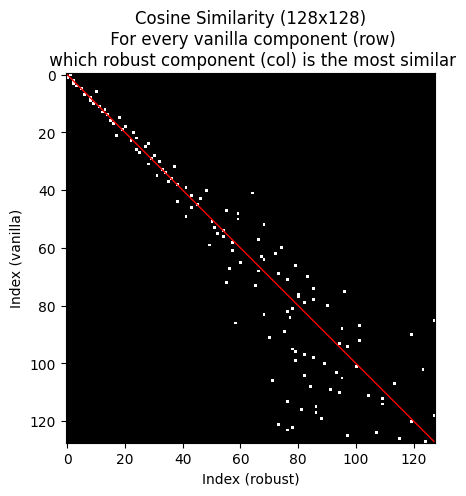

In [64]:
# Create a heatmap
plt.imshow(cos_matrix_highest, cmap='gray', interpolation='nearest')

# Add color bar to show the scale
#plt.colorbar()

# Add title and labels if needed
plt.title('Cosine Similarity (128x128)\n For every vanilla component (row)\n which robust component (col) is the most similar')
plt.xlabel('Index (robust)')
plt.ylabel('Index (vanilla)')

# Draw a red line from (0,0) to (127,127)
plt.plot([0, 127], [0, 127], color='red', linestyle='-', linewidth=1)

# Display the heatmap
plt.show()

In [53]:
# Initialize the new matrix with zeros
eucl_matrix_lowest = np.zeros_like(eucl_matrix)

# Get the index of the maximum value in each row
min_indices = np.argmin(eucl_matrix, axis=1)

# Set the corresponding indices to 1
for i, idx in enumerate(min_indices):
    eucl_matrix_lowest[i, idx] = 1

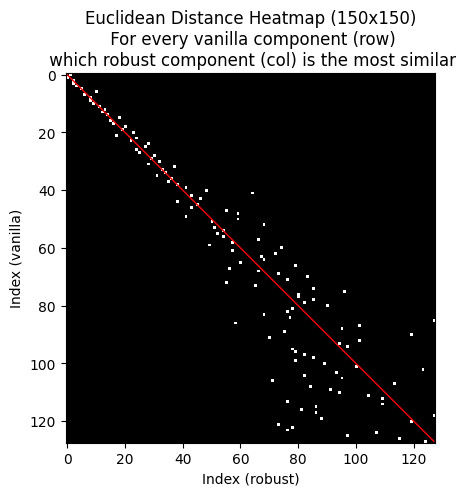

In [54]:
# Create a heatmap
plt.imshow(eucl_matrix_lowest[:150,:150], cmap='gray', interpolation='nearest')

# Add color bar to show the scale
#plt.colorbar()

# Add title and labels if needed
plt.title('Euclidean Distance Heatmap (150x150)\n For every vanilla component (row)\n which robust component (col) is the most similar')
plt.xlabel('Index (robust)')
plt.ylabel('Index (vanilla)')

# Draw a red line from (0,0) to (127,127)
plt.plot([0, 127], [0, 127], color='red', linestyle='-', linewidth=1)

# Display the heatmap
plt.show()

In [55]:
max_cos_val = np.max(cos_matrix, axis=1)
print(max_cos_val)

[0.75748473 0.77013099 0.71870297 0.57742512 0.79482806 0.59436959
 0.78472215 0.69181466 0.60357368 0.44389302 0.76972795 0.66228157
 0.67569947 0.68134993 0.67668885 0.55309856 0.54910058 0.42179191
 0.56477702 0.48423502 0.60633981 0.65521097 0.51236016 0.60761726
 0.4472543  0.48424414 0.49742344 0.40057948 0.44918892 0.42599595
 0.45861119 0.54040211 0.5202105  0.52541918 0.36930099 0.31876156
 0.39240384 0.54679328 0.38102877 0.49142638 0.33184063 0.32992128
 0.35901329 0.44203588 0.42896912 0.39726958 0.35578623 0.32891804
 0.29171413 0.38811231 0.26218331 0.3103849  0.3975811  0.27128279
 0.34311971 0.26516849 0.27121499 0.32298747 0.31762058 0.2561737
 0.20132504 0.24664554 0.1977879  0.26501429 0.24423912 0.28073323
 0.21008047 0.21015076 0.20236354 0.18608344 0.21664348 0.21994705
 0.18087736 0.24772063 0.28026778 0.13852005 0.17719647 0.1880585
 0.19922873 0.2091523  0.20002289 0.2060018  0.1580794  0.15189777
 0.15044755 0.18423639 0.14346002 0.1465288  0.13780931 0.151523

In [56]:
print(np.round(max_cos_val,3))

[0.757 0.77  0.719 0.577 0.795 0.594 0.785 0.692 0.604 0.444 0.77  0.662
 0.676 0.681 0.677 0.553 0.549 0.422 0.565 0.484 0.606 0.655 0.512 0.608
 0.447 0.484 0.497 0.401 0.449 0.426 0.459 0.54  0.52  0.525 0.369 0.319
 0.392 0.547 0.381 0.491 0.332 0.33  0.359 0.442 0.429 0.397 0.356 0.329
 0.292 0.388 0.262 0.31  0.398 0.271 0.343 0.265 0.271 0.323 0.318 0.256
 0.201 0.247 0.198 0.265 0.244 0.281 0.21  0.21  0.202 0.186 0.217 0.22
 0.181 0.248 0.28  0.139 0.177 0.188 0.199 0.209 0.2   0.206 0.158 0.152
 0.15  0.184 0.143 0.147 0.138 0.152 0.132 0.172 0.164 0.162 0.131 0.212
 0.162 0.16  0.128 0.143 0.118 0.128 0.131 0.192 0.175 0.131 0.133 0.114
 0.113 0.131 0.134 0.094 0.11  0.125 0.129 0.105 0.127 0.136 0.097 0.086
 0.112 0.111 0.097 0.122 0.102 0.096 0.123 0.104]


C:\Users\gcorl\AppData\Local\Temp\ipykernel_12196\3879636864.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet') #viridis


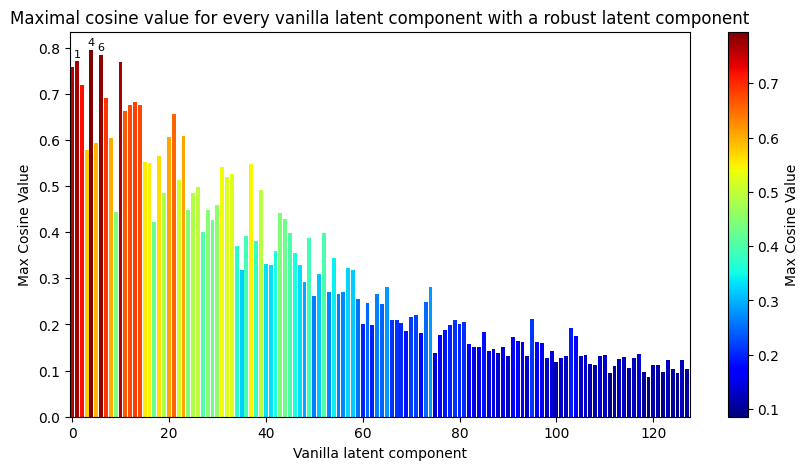

In [67]:
# Create an array of indices for the x-axis
x = np.arange(len(max_cos_val))

# Normalize the max_cos_val data to the range [0, 1]
norm = mcolors.Normalize(vmin=np.min(max_cos_val), vmax=np.max(max_cos_val))
# Create the RdBu colormap
cmap = cm.get_cmap('jet') #viridis
# Apply the colormap to the normalized data to get colors
colors = cmap(norm(max_cos_val))

# Create the bar chart
#plt.figure(figsize=(10, 5))
#plt.bar(x, max_cos_val, color = colors)
#plt.xlabel('Vanilla latent component')
#plt.ylabel('Max Cosine Value')
#plt.title('Maximal cosine value for every vanilla latent component with a robust latent component')
#plt.margins(x=0)

# Create the bar chart with colors
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(x, max_cos_val, color=colors)
ax.set_xlabel('Vanilla latent component')
ax.set_ylabel('Max Cosine Value')
ax.set_title('Maximal cosine value for every vanilla latent component with a robust latent component')
ax.set_xlim(-0.5, len(max_cos_val) - 0.5)

# Create a scalar mappable for the colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Add the colorbar to the plot
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Max Cosine Value')

# Annotate bars with the maximum value
#max_value = np.max(max_cos_val)
#for i, value in enumerate(max_cos_val):
    #if value == max_value:
        #ax.text(i, value + 0.005, str(i), ha='center', va='bottom', fontsize=8, color='black')

# Annotate bars with the three highest values
# Get indices of the three highest values
#top3_indices = np.argsort(max_cos_val)[-3:]

# Annotate bars with the three highest values (considering ties for third highest)
# Get the unique values sorted in descending order
unique_values = np.unique(max_cos_val)
# Check if there are at least three unique values
if len(unique_values) >= 3:
    # Get the third highest value
    third_highest_value = unique_values[-3]
else:
    # If less than three unique values, use the lowest unique value as third highest
    third_highest_value = unique_values[0]

# Find all indices with values greater than or equal to the third highest value
top3_indices = np.where(max_cos_val >= third_highest_value)[0]

for i in top3_indices:
    ax.text(i, max_cos_val[i] + 0.005, f'{i}', ha='center', va='bottom', fontsize=8, color='black')


plt.show()

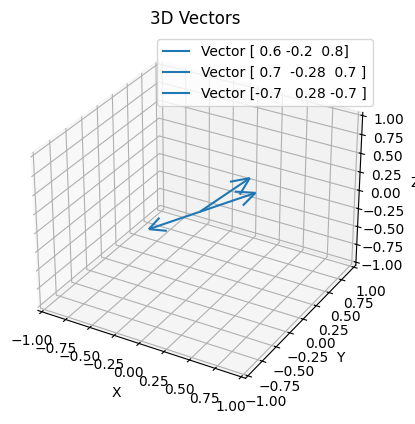

In [54]:
# Define the vectors
vectors = np.array([
    [0.6, -0.2, 0.8],
    [0.7, -0.28, 0.7],
    [-0.7, 0.28, -0.7]
])

# Create a new figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Origin
origin = np.array([0, 0, 0])

# Plot each vector
for vector in vectors:
    ax.quiver(*origin, *vector, label=f'Vector {vector}')

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set limits
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

# Add a legend
ax.legend()

# Set the title
ax.set_title('3D Vectors')

# Show the plot
plt.show()

Possibility is a greedy search: </br>
Look for the most similar component for component 1, remove it from the possibities and do for the second component etc. </br>
Other possibility is to choose the optimal pairs by minimizing a loss function (optimization problem)</br>
Total dissimilarity as small as possible

Code from Naichuan

In [ ]:
# print(np.abs(np.argsort(cos_sim) - np.arange(500)).mean())
# print(np.sort(cos_sim)[::-1])

# method 1: multiply a constant on 'robust eigenvectors'
# top_m = np.argsort(euc_dist)[:30]
# h[:, top_m] *= 10

# method 2: replace the first n` vectors in h with h`
# n = 100
# h[:, :n] = h_[:, :n] * 10
# s[:n] = s_[:n]

In [ ]:
# comp = (1, 137, 19, 469, 388, 107)
comp = (1, 19, 4, 57)
# print(h.var(dim=0))
nbr_image = 5
m = 11
perturbation = np.linspace(-3, 3, m)
fig1, ax = plt.subplots(m, len(comp))
for i in range(m):
    for j in range(len(comp)):
        h_try = copy.deepcopy(h)
        h_try[nbr_image, comp[j]] += perturbation[i] * h[:, comp[j]].std()
        # x_gen_base = net3(torch.mv(U, h[nbr_image, :])).detach().numpy()
        print(U.shape, h_try[nbr_image, :].shape)
        x_gen_try = net3(torch.mv(U, h_try[nbr_image, :])).detach().numpy()

        ax[i, j].imshow(x_gen_try[0, 0, :], cmap='Greys_r')
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
plt.show()

In [ ]:
nbr_comp = 200
index1 = np.arange(nbr_comp)
index2 = np.argsort(cos_sim)[:nbr_comp]
index3 = np.argsort(cos_sim)[::-1][:nbr_comp]
idx_list = [index1, index2, index3]

fig2, ax = plt.subplots(1, 3)
for k in range(3):
    h_try = h.clone()
    U_try = U.clone()
    idx = idx_list[k]

    U_try[:, np.setdiff1d(np.arange(U_try.shape[1]), idx)] = 0
    h_try[:, np.setdiff1d(np.arange(h_try.shape[1]), idx)] = 0
    x_gen_try = net3(torch.mv(U[:, :], h_try[nbr_image, :])).cpu().detach().numpy()
    ax[k].imshow(x_gen_try[0, 0, :], cmap='Greys_r')
    ax[k].set_xticks([])
    ax[k].set_yticks([])
plt.show()

In [ ]:

# print(h.var(dim=0))
fig3, ax = plt.subplots(m, len(comp))
for i in range(m):
    for j in range(len(comp)):
        h_try = h.clone()
        U_try = U.clone()
        idx = index2
        U_try[:, np.setdiff1d(np.arange(U_try.shape[1]), idx)] = 0
        h_try[:, np.setdiff1d(np.arange(h_try.shape[1]), idx)] = 0
        h_try[nbr_image, comp[j]] += perturbation[i] * h[:, comp[j]].std()
        # x_gen_base = net3(torch.mv(U, h[nbr_image, :])).detach().numpy()
        x_gen_try = net3(torch.mv(U, h_try[nbr_image, :])).detach().numpy()

        ax[i, j].imshow(x_gen_try[0, 0, :], cmap='Greys_r')
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
plt.show()

In [ ]:
# comp = ()
fig4, ax = plt.subplots(m, len(comp))
for i in range(m):
    for j in range(len(comp)):
        h_try = h.clone()
        U_try = U.clone()
        idx = index1
        U_try[:, np.setdiff1d(np.arange(U_try.shape[1]), idx)] = 0
        h_try[:, np.setdiff1d(np.arange(h_try.shape[1]), idx)] = 0
        h_try[nbr_image, comp[j]] += perturbation[i] * h[:, comp[j]].std()
        # x_gen_base = net3(torch.mv(U, h[nbr_image, :])).detach().numpy()
        x_gen_try = net3(torch.mv(U, h_try[nbr_image, :])).detach().numpy()

        ax[i, j].imshow(x_gen_try[0, 0, :], cmap='Greys_r')
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
plt.show()